# NRI Landuse Data

Estimate the rate of forest land use change



In [3]:
# setup workspace
import pandas as pd


In [4]:
# load 2017 NRI data
filePath = '/Users/mihiarc/Work/data/NRI2017/'
nri17 = pd.read_csv(filePath + 'nri17_csv.csv')

/var/folders/c9/dwfk30c575n0dw3tkq6prd940000gn/T/ipykernel_4542/1692438488.py:3: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  nri17 = pd.read_csv(filePath + 'nri17_csv.csv')


In [8]:
# explore the data
nri17.head()

,state,county,fips,wcfact,rfact,xfact,soilname,texture,floodcl,ssaid,...,w2r24,w2r25,w2r26,w2r27,w2r28,w2r29,riad_id,updated_fips,updated_state,updated_county
0,1,1,1001,0,375,3,NaN,NaN,NaN,NaN,...,300,300,300,300,300,300,1,1001,1,1
1,1,1,1001,0,375,4,NaN,NaN,NaN,NaN,...,400,400,400,400,400,400,2,1001,1,1
2,1,1,1001,0,375,1,NaN,NaN,NaN,NaN,...,100,100,100,100,100,100,3,1001,1,1
3,1,1,1001,0,375,2,NaN,NaN,NaN,NaN,...,200,200,200,200,200,200,4,1001,1,1
4,1,1,1001,0,375,17,NaN,NaN,NaN,NaN,...,1700,1700,1700,1700,1700,1700,5,1001,1,1


Since we are only interested in forest related changes, we can drop all variables except the id vars and the broad categories of forest, cropland, and pasture.

* riad_id: unique plot identifier
* state: state fips code
* county: county code
* fips: unique county code
* xfact: expansion factor equal to 100s of acres
* broadYR: broad land use code with year of observation

In [9]:
# Select columns that start with 'broad'
broad_columns = nri17.filter(like='broad').columns.tolist()

# Combine with other specific columns you need
selected_columns = ['riad_id', 'state', 'county', 'fips', 'xfact'] + broad_columns

# Create a new DataFrame with the selected columns
nri17_selected = nri17[selected_columns]

# Display the new DataFrame
print(nri17_selected)

         riad_id  state  county   fips  xfact  broad82  broad87  broad92  \
0              1      1       1   1001      3       11        5        5   
1              2      1       1   1001      4       11       11       11   
2              3      1       1   1001      1       11       11       11   
3              4      1       1   1001      2       11       11       11   
4              5      1       1   1001     17       10       10       10   
...          ...    ...     ...    ...    ...      ...      ...      ...   
1383057  1383058     72     135  72135      6        5        7        7   
1383058  1383059     72     135  72135      1       10       10       10   
1383059  1383060     72     135  72135      1       10       10       10   
1383060  1383061     72     135  72135      1       10       10       10   
1383061  1383062     72     135  72135      1       10       10       10   

         broad97  broad00  ...  broad08  broad09  broad10  broad11  broad12  \
0       

Recode the land use types and reshape to long.

In [15]:
# reshape the data to long format
nri17_long = nri17_selected.melt(id_vars=['riad_id', 'state', 'county', 'fips', 'xfact'],
                                  var_name='year',
                                  value_name='buCode')

# in column 'year' extract the last 2 characters
nri17_long['year'] = nri17_long['year'].str[-2:].astype(int)

# add 1900 to year if greater than 17, and 2000 if less than or equal to 17
nri17_long['year'] = nri17_long['year'].apply(
    lambda x: 1900 + x if x > 17 else 2000 + x)

# define a dictionary that maps the broad category code to the category name
broad_code_to_name = {
    '1': 'Crop',
    '2': 'Crop',
    '3': 'Pasture',
    '4': 'Range',
    '5': 'Forest',
    '6': 'OtherAg',
    '7': 'Urban',
    '8': 'OtherAg',
    '9': 'Water',
    '10': 'Water',
    '11': 'Federal',
    '12': 'OtherAg', #CRP
}

# convert buCode to string
nri17_long['buCode'] = nri17_long['buCode'].astype(str)
# use the dictionary to map value to the category name
nri17_long['broadUse'] = nri17_long['buCode'].map(broad_code_to_name)

# keep only the rows where broadUse is crop, pasture, forest, or other ag.
nri17_long = nri17_long[nri17_long['broadUse'].isin(
    ['Crop', 'Pasture', 'Forest', 'OtherAg'])]

# drop buCode
nri17_long = nri17_long.drop('buCode', axis=1)

# xfact is acres in 100s, convert to millions of cares
nri17_long['xfact'] = nri17_long['xfact'] / 10**4

# pivot wide so that each broadUse has its own column using xfact as the value
nri17_long = nri17_long.pivot_table(index=['state', 'county', 'fips', 'year'],
                                    columns='broadUse',
                                    values='xfact',
                                    aggfunc='sum').reset_index()

# Display the result
print(nri17_long)


broadUse  state  county   fips  year    Crop  Forest  OtherAg  Pasture
0             1       1   1001  1982  0.0570  0.2375   0.0136   0.0560
1             1       1   1001  1987  0.0450  0.2420   0.0168   0.0583
2             1       1   1001  1992  0.0360  0.2437   0.0230   0.0581
3             1       1   1001  1997  0.0260  0.2498   0.0212   0.0599
4             1       1   1001  2000  0.0279  0.2487   0.0205   0.0538
...         ...     ...    ...   ...     ...     ...      ...      ...
67986        72     135  72135  2013  0.0001  0.0272   0.0026   0.0015
67987        72     135  72135  2014  0.0001  0.0272   0.0026   0.0015
67988        72     135  72135  2015  0.0001  0.0272   0.0026   0.0015
67989        72     135  72135  2016  0.0001  0.0272   0.0026   0.0015
67990        72     135  72135  2017  0.0001  0.0272   0.0026   0.0015

[67991 rows x 8 columns]


Calculate the total area in each category over time.

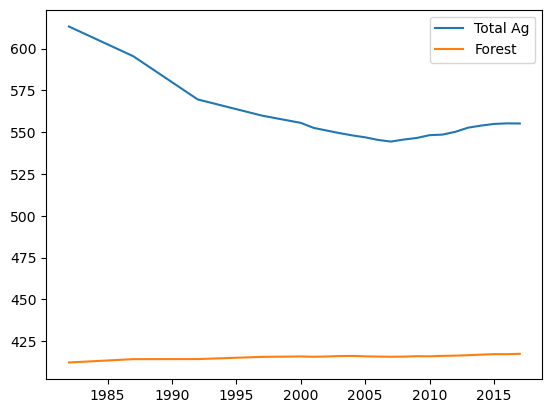

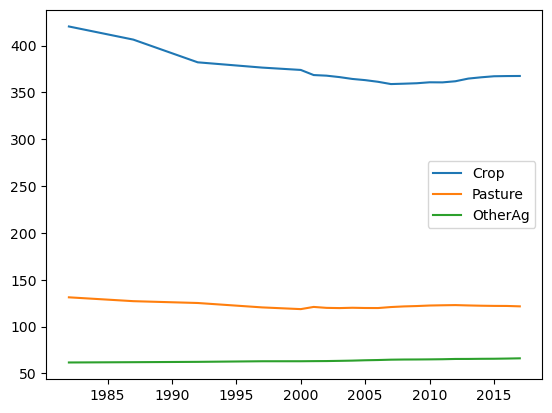

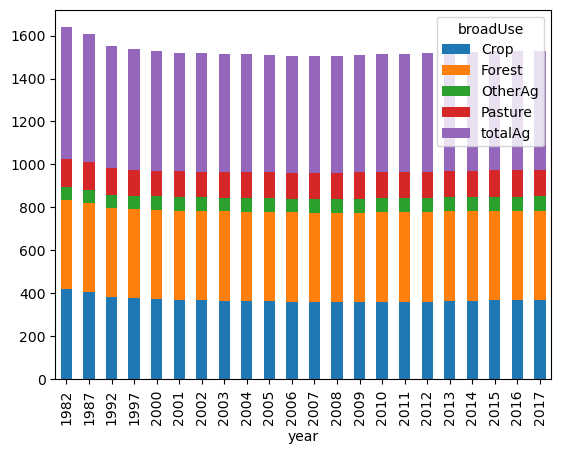

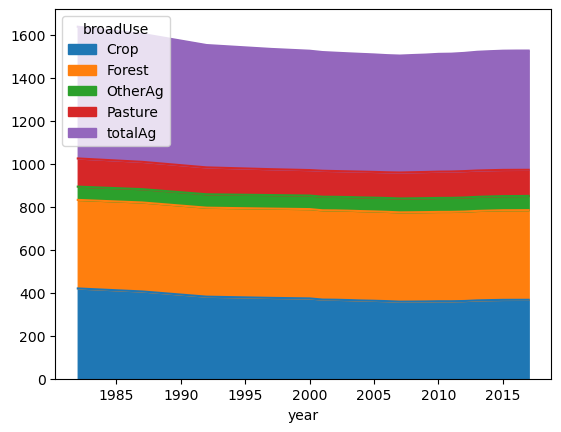

In [12]:
# Calculate the total area in each broad use category over time

# drop state, county, and fips columns
result = nri17_long.drop(['state', 'county', 'fips'], axis=1)

# aggregate the data by year and sum the area in each broad use category
result = result.groupby('year').sum().reset_index()

# calculate totalAg as the sum of crop, pasture, and otherag
result['totalAg'] = result['Crop'] + result['Pasture'] + result['OtherAg']

# use a line plot to compare totalAg and Forest over time
import matplotlib.pyplot as plt

plt.plot(result['year'], result['totalAg'], label='Total Ag')
plt.plot(result['year'], result['Forest'], label='Forest')
plt.legend()

# add a facet that shows crop, pasture, and otherag together
plt.figure()
plt.plot(result['year'], result['Crop'], label='Crop')
plt.plot(result['year'], result['Pasture'], label='Pasture')
plt.plot(result['year'], result['OtherAg'], label='OtherAg')
plt.legend()

# add a facet that uses a stacked bar chart to show the area of each broad use category over time
result.plot(x='year', kind='bar', stacked=True)

# add a facet that uses a stacked area chart to show the area of each broad use category over time
result.plot(x='year', kind='area', stacked=True)

# show the plots
plt.show()



Now calculate acres converted between broad uses.

In [18]:
# in NRI17_selected, each row is a unique plot observation. 
# the columns broad82, broad87, etc is the land use observed in that year,
# where the year is the last 2 characters of the column name.
# xfact is the area of the plot in 100s of acres.

# the objective is to track how each plot changes over time. 

# rename broad columns to year
nriChanges = nri17_selected.rename(columns={'broad82': '1982',
                                            'broad87': '1987',
                                            'broad92': '1992',
                                            'broad97': '1997',
                                            'broad00': '2000',
                                            'broad01': '2001',
                                            'broad02': '2002',
                                            'broad03': '2003',
                                            'broad04': '2004',
                                            'broad05': '2005',
                                            'broad06': '2006',
                                            'broad07': '2007',
                                            'broad08': '2008',
                                            'broad09': '2009',
                                            'broad10': '2010',
                                            'broad11': '2011',
                                            'broad12': '2012',
                                            'broad13': '2013',
                                            'broad14': '2014',
                                            'broad15': '2015',
                                            'broad16': '2016',
                                            'broad17': '2017'})

# in columns 1982:2017, recode values using the dictionary broad_code_to_name
nriChanges = nriChanges.melt(id_vars=['riad_id', 'state', 'county', 'fips', 'xfact'],
                               var_name='year',
                               value_name='buCode')





# nriChanges['year'] = nriChanges['year'].str[-2:].astype(int)
# nriChanges['year'] = nriChanges['year'].apply(
#     lambda x: 1900 + x if x > 17 else 2000 + x)

# nriChanges['buCode'] = nriChanges['buCode'].astype(str)
# nriChanges['broadUse'] = nriChanges['buCode'].map(broad_code_to_name)


### For each riad_id, calculate the change in land use over time. Not including forest remaining forest, there are 6 possible transition types related to forest change:

1. crop to forest
2. pasture to forest
3. other ag to forest
4. forest to crop
5. forest to pasture
6. forest to other ag

In [19]:
# for each plot and year, calculate a new column 'change' that identifies the 
# transition type from the previous year. if no change, set to 'noChange'
# if broadUse changes from (1 or 2) to 5, set to 'cropToForest'
# if broadUse changes from 5 to (1 or 2), set to 'forestToCrop'
# if broadUse changes from 3 to 5, set to 'pastureToForest'
# if broadUse changes from 5 to 3, set to 'forestToPasture'
# if broadUse changes from (6 or 8) to 5, set to 'otherAgToForest'
# if broadUse changes from 5 to (6 or 8), set to 'forestToOtherAg'

# group the data by riad_id and sort by year
nriChanges = nriChanges.groupby('riad_id').apply(
    lambda x: x.sort_values('year')).reset_index(drop=True)




/var/folders/c9/dwfk30c575n0dw3tkq6prd940000gn/T/ipykernel_4542/2437809348.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nriChanges = nriChanges.groupby('riad_id').apply(


In [24]:
# convert buCode to string
nriChanges['buCode'] = nriChanges['buCode'].astype(str)

# recode buCode to broadUse using the dictionary broad_code_to_name
nriChanges['broadUse'] = nriChanges['buCode'].map(broad_code_to_name)

# for each riad_id record the change in broadUse from the previous year
# by concatenating the broadUse values from the current and previous year
nriChanges['change'] = nriChanges.groupby('riad_id')['broadUse'].shift(
    fill_value='noChange') + 'To' + nriChanges['broadUse']

# # create a new column 'change' and set to 'noChange'
# nriChanges['change'] = 'noChange'

# # set change to 'cropToForest' if broadUse changes from (1 or 2) to 5
# nriChanges['change'] = nriChanges['change'].where(
#     nriChanges['1982'] == nriChanges['1987'].shift(), 'noChange')

In [30]:
# filter the data to only include riad_ids that have relevant changes
nriChanges = nriChanges[nriChanges['change'].isin(
    ['CropToForest', 'ForestToCrop', 'PastureToForest',
     'ForestToPasture', 'OtherAgToForest', 'ForestToOtherAg'])]

# group by fips, year, and change, and sum the xfact
nriChangesCounty = nriChanges.groupby(
    ['fips', 'year', 'change'])['xfact'].sum().reset_index()

# convert xfact (100s acres) to acres
nriChangesCounty['milAcres'] = nriChangesCounty['xfact'] * 100

# pivot the data so that each year has its own column
nriChangesCounty = nriChangesCounty.pivot_table(index=['fips', 'year'],
                                                columns='change',
                                                values='milAcres',
                                                fill_value=0).reset_index()

# make new column that is all ag to forest and another that is forest to all ag
nriChangesCounty['allAgToForest'] = nriChangesCounty['CropToForest'] + \
    nriChangesCounty['PastureToForest'] + nriChangesCounty['OtherAgToForest']

nriChangesCounty['forestToAllAg'] = nriChangesCounty['ForestToCrop'] + \
    nriChangesCounty['ForestToPasture'] + nriChangesCounty['ForestToOtherAg']

